# 토픽모델링_178주차

## 0. 라이브러리 임포트

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. 파일 불러오기

In [11]:
import pandas as pd
df_178 = pd.read_csv("df_178.csv", encoding="utf-8")
df_178.head(3)

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams
0,2023-05-31,머리 덥수룩한 성범죄자상 아재가,https://gall.dcinside.com/board/view/?id=cs_ne...,cs_new1,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배사려다가 거래정지 떴는데 이거 분실카...,0,178,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배 사려다가 거래 정지 떴는데 이 거 ...,"['머리', '성범죄', '자상', '아재', '토스카드', '담배', '거래', ...","['머리 성범죄', '성범죄 자상', '자상 아재', '아재 토스카드', '토스카드..."
1,2023-05-31,팅고 이거 ㅂㅅ이네,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,팅고 이거 ㅂㅅ이네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인가 싶었는데헤지펀드들이 ...,0,178,팅 고 이 거 ㅂㅅ이 네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인 가 싶었는데 헤지...,"['ㅂㅅ', '실적', '괴리', 'ㅈㄴ', '평가', '헤지', '펀드', '바보...","['ㅂㅅ 실적', '실적 괴리', '괴리 ㅈㄴ', 'ㅈㄴ 평가', '평가 헤지', ..."
2,2023-05-31,Ards 오랜만,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설...,0,178,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설계...,"['오랜만', '단일', '확인', '연구', '임상', '연구', '설계', '계...","['오랜만 단일', '단일 확인', '확인 연구', '연구 임상', '임상 연구',..."


### 갤러리 분포 시각화

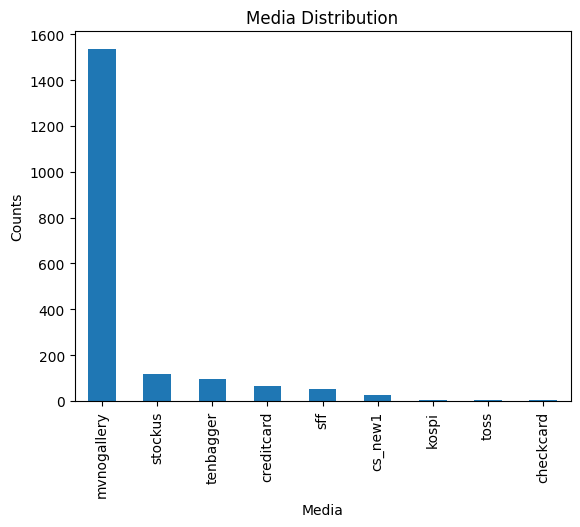

In [70]:
# 'media' 칼럼의 분포 시각화
media_counts = df_178['media'].value_counts()
media_counts.plot(kind='bar', title='Media Distribution')
plt.xlabel('Media')
plt.ylabel('Counts')
plt.show()

### 날짜 분포 시각화

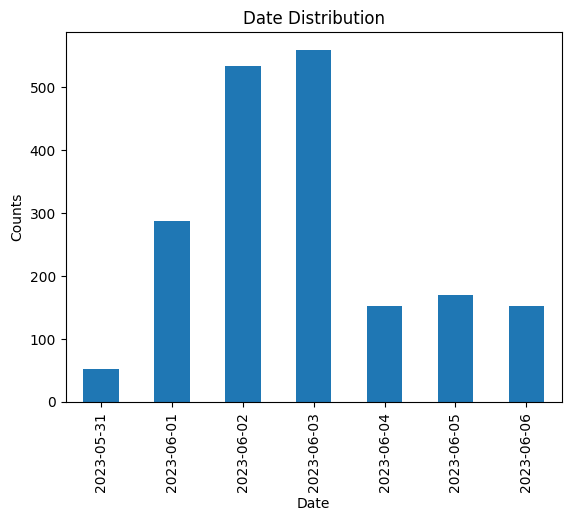

In [80]:
# 'date' 칼럼의 날짜별 분포 시각화
date_counts = df_178['date'].value_counts().sort_index()
date_counts.plot(kind='bar', title='Date Distribution')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

## 2. 토픽모델링에 적절한 토픽 수 판단

### 2-a. 적절한 토픽 수 판단 : perplexity, Coherence 기반

In [23]:
# 토큰을 리스트 형태로 변환
df_178['tokens_list'] = df_178['tokens'].apply(lambda x: ast.literal_eval(x))
df_178.head()

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams,tokens_list
0,2023-05-31,머리 덥수룩한 성범죄자상 아재가,https://gall.dcinside.com/board/view/?id=cs_ne...,cs_new1,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배사려다가 거래정지 떴는데 이거 분실카...,0,178,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배 사려다가 거래 정지 떴는데 이 거 ...,"['머리', '성범죄', '자상', '아재', '토스카드', '담배', '거래', ...","['머리 성범죄', '성범죄 자상', '자상 아재', '아재 토스카드', '토스카드...","[머리, 성범죄, 자상, 아재, 토스카드, 담배, 거래, 정지, 분실, 카드]"
1,2023-05-31,팅고 이거 ㅂㅅ이네,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,팅고 이거 ㅂㅅ이네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인가 싶었는데헤지펀드들이 ...,0,178,팅 고 이 거 ㅂㅅ이 네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인 가 싶었는데 헤지...,"['ㅂㅅ', '실적', '괴리', 'ㅈㄴ', '평가', '헤지', '펀드', '바보...","['ㅂㅅ 실적', '실적 괴리', '괴리 ㅈㄴ', 'ㅈㄴ 평가', '평가 헤지', ...","[ㅂㅅ, 실적, 괴리, ㅈㄴ, 평가, 헤지, 펀드, 바보, 공매, 오지, 때리, 토..."
2,2023-05-31,Ards 오랜만,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설...,0,178,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설계...,"['오랜만', '단일', '확인', '연구', '임상', '연구', '설계', '계...","['오랜만 단일', '단일 확인', '확인 연구', '연구 임상', '임상 연구',...","[오랜만, 단일, 확인, 연구, 임상, 연구, 설계, 계약, 체결, 오전, 로스, ..."
3,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,그럼 뭐때메 내림?,1,178,그럼 뭐 때 메 내림?,['내림'],['내림'],[내림]
4,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,공매도 아는게 어디냐...,1,178,공매도 아는 게 어디냐...,['공매'],['공매'],[공매]


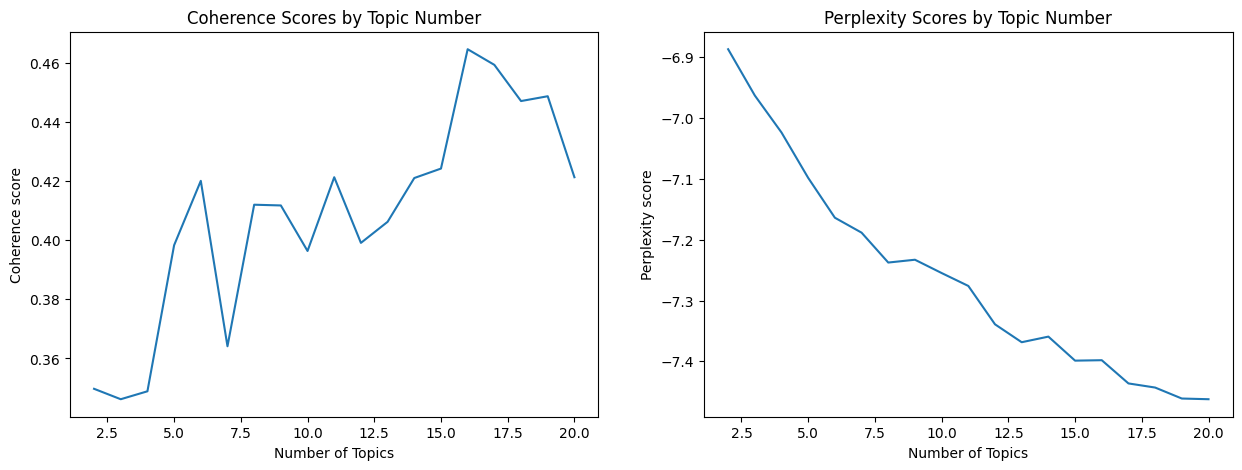

In [24]:
# Gensim 사전 및 코퍼스 생성
dictionary = corpora.Dictionary(df_178['tokens_list'])
corpus = [dictionary.doc2bow(text) for text in df_178['tokens_list']]

# 토픽 수에 따른 LDA 모델 학습 및 평가
min_topics = 2
max_topics = 20
step_size = 1
coherence_values = []
perplexity_values = []

for num_topics in range(min_topics, max_topics + 1, step_size):
    model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)
    coherencemodel = CoherenceModel(model=model, texts=df_178['tokens_list'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    perplexity_values.append(model.log_perplexity(corpus))

# 결과 시각화
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Topic Number")

plt.subplot(1, 2, 2)
plt.plot(range(min_topics, max_topics + 1, step_size), perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity score")
plt.title("Perplexity Scores by Topic Number")

plt.show()

### 2-b. 결과
- perplexity는 낮을수록 좋음
- Coherence는 높을 수록 좋음
- 그래프를 토대로, 적절한 토픽수는 16로 결정함

In [31]:
n_components=16

## 3. 토픽모델링 진행

### 3-a. 토픽모델링 후 모델을 파일로 저장

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib

# 'tokens' 칼럼을 문자열로 변환
tokens_str = df_178['tokens'].apply(lambda x: ' '.join(eval(x)))

# CountVectorizer를 사용하여 텍스트 데이터를 용어 빈도(TF) 행렬로 변환
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
X_with_tokens = vectorizer.fit_transform(tokens_str)

# LDA 모델 생성 및 학습
lda_model = LatentDirichletAllocation(
    n_components=n_components,  # 토픽의 수
    doc_topic_prior=0.01,  # 알파 값
    max_iter=1000,  # 반복 횟수
    n_jobs=-1,  # 병렬 처리 설정
    verbose=1  # 상세한 로그 출력
)
lda_model.fit(X_with_tokens)

# 모델 저장
model_file_path = "./lda_model_178.joblib"  # 저장할 파일 이름
joblib.dump(lda_model, model_file_path)  # LDA 모델을 파일로 저장

print("lda 모델 저장 완료")

iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000
iteration: 26 of max_iter: 1000
iteration: 27 of max_iter: 1000
iteration: 28 of max_iter: 1000
iteration: 29 of max_iter: 1000
iteration: 30 of max_iter: 1000
iteration: 31 of max_iter: 1000
iteration: 32 of 

In [51]:
# 저장된 모델 불러오기
lda_model = joblib.load("lda_model_178.joblib")

# 토픽-단어 분포와 특징 이름 추출
topic_word_distributions = lda_model.components_
feature_names = vectorizer.get_feature_names_out()

# 상위 단어들을 보여주는 토픽 요약
num_top_words = n_components  # 몇 개 출력할 것인지 정하기
topic_summaries = {}

for i, topic_word_distribution in enumerate(topic_word_distributions):
    top_words = [feature_names[j] for j in topic_word_distribution.argsort()[:-num_top_words - 1:-1]]
    topic_summaries[i] = ' '.join(top_words)

# 토픽의 상위 단어들을 예시로 보여줌
topic_summaries_top = {key: topic_summaries[key] for key in list(topic_summaries)[:num_top_words]}
topic_summaries_top, model_file_path

({0: '전화 토스 포인트 문자 이벤트 업체 통화 달러 나중 거임 데이터 사용량 해피 ㄴㄴ 토스증권 용돈',
  1: '토스 중립 리브엠 통장 고민 회사 오늘 보내 하루 넘어가 이름 예전 카드 많음 체크 와이파이',
  2: '토스 하나 서브 황족 이상 명박 걱정 아쉽 메인 회선 종토방 5천 상관없 버그 솔직히 미납',
  3: '요금제 토스 0원 갈아타 들어가 캐쉬백 프로모션 신세계 최대 갈아 메뉴 1만원 적립 상품권 메뚜기 가능',
  4: '토스 회선 지원금 재난 택배 메뚜기 종료 ㅈㄴ 조기 취소 테크 세븐 상품권 동네 우리 뽐뿌',
  5: '출금 토스 토스페이 5만원 결제 카드 편의점 캐시백 주문 할인 5천원 현금 배달 개꿀 만원 등록',
  6: '무료 사용 할인 요금 기간 공짜 11월 추천 토스 약정 바꾸 해지 0원 계산 데이터 이용',
  7: '캐시백 토스 요금제 가입 토스모바일 0원 동안 페이지 3만원 5만원 토요일 5개월 모르 나라 증권사 이벤트',
  8: '신청 모바일 기준 상담 요금제 적용 혜택 내용 답변 부분 모르 토스 바뀌 입력 어제 확인',
  9: '토스 계좌 알뜰폰 수수료 제한 토스뱅크 은행 저거 보이 발급 만들 서비스 비싸 기존 확인 매수',
  10: '0원 토스 이번 페이백 그러 얼마 5만 이유 인터넷 쿠팡 필요 공시 기능 자기 ㅎㅎ 점유',
  11: '신청 개통 토스 유심 0원 정보 신규 5만원 어케 월요일 사용 방금 회선 처음 귀찮 다음',
  12: '개통 토스 데이터 유심 시간 완료 추가 캐시백 문제 셀프 적용 무제한 전화 다음 맞음 문의',
  13: '가입 번호 토스 신규 이동 번이 해지 감사 공기 가입자 나가 불편 30분 그렇 버리 이해',
  14: '가능 해지 토스 거래 확인 기가 걸리 차이 가격 정지 ㄱㅅㄱㅅ 바이럴 속도 결과 5만원 기본',
  15: '유심 토스 배송 신청 개통 주식 모바일 도착 빠르 알뜰폰 고객센터 시간 번호 새벽 감동 세븐'},
 './lda_model_178.joblib')

### 3-b. df_178에 topic 칼럼 만들기

In [36]:
df_178.head()

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams
0,2023-05-31,머리 덥수룩한 성범죄자상 아재가,https://gall.dcinside.com/board/view/?id=cs_ne...,cs_new1,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배사려다가 거래정지 떴는데 이거 분실카...,0,178,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배 사려다가 거래 정지 떴는데 이 거 ...,"[머리, 성범죄, 자상, 아재, 토스카드, 담배, 거래, 정지, 분실, 카드]","['머리 성범죄', '성범죄 자상', '자상 아재', '아재 토스카드', '토스카드..."
1,2023-05-31,팅고 이거 ㅂㅅ이네,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,팅고 이거 ㅂㅅ이네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인가 싶었는데헤지펀드들이 ...,0,178,팅 고 이 거 ㅂㅅ이 네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인 가 싶었는데 헤지...,"[ㅂㅅ, 실적, 괴리, ㅈㄴ, 평가, 헤지, 펀드, 바보, 공매, 오지, 때리, 토...","['ㅂㅅ 실적', '실적 괴리', '괴리 ㅈㄴ', 'ㅈㄴ 평가', '평가 헤지', ..."
2,2023-05-31,Ards 오랜만,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설...,0,178,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설계...,"[오랜만, 단일, 확인, 연구, 임상, 연구, 설계, 계약, 체결, 오전, 로스, ...","['오랜만 단일', '단일 확인', '확인 연구', '연구 임상', '임상 연구',..."
3,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,그럼 뭐때메 내림?,1,178,그럼 뭐 때 메 내림?,[내림],['내림']
4,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,공매도 아는게 어디냐...,1,178,공매도 아는 게 어디냐...,[공매],['공매']


In [44]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import ast

# 데이터프레임 불러오기
df_178 = pd.read_csv('df_178.csv')

# 'tokens' 칼럼을 문자열로 변환
df_178['tokens_str'] = df_178['tokens'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# CountVectorizer 설정 (LDA 모델 학습 시 사용된 설정과 동일)
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
X = vectorizer.fit_transform(df_178['tokens_str'])

# 저장된 LDA 모델 불러오기
lda_model = joblib.load('lda_model_178.joblib')

# 각 문서에 대한 토픽 분포 예측
doc_topic_distributions = lda_model.transform(X)

# 각 문서의 주요 토픽 결정
df_178['topic'] = doc_topic_distributions.argmax(axis=1)

df_178.head()

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams,tokens_str,topic
0,2023-05-31,머리 덥수룩한 성범죄자상 아재가,https://gall.dcinside.com/board/view/?id=cs_ne...,cs_new1,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배사려다가 거래정지 떴는데 이거 분실카...,0,178,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배 사려다가 거래 정지 떴는데 이 거 ...,"['머리', '성범죄', '자상', '아재', '토스카드', '담배', '거래', ...","['머리 성범죄', '성범죄 자상', '자상 아재', '아재 토스카드', '토스카드...",머리 성범죄 자상 아재 토스카드 담배 거래 정지 분실 카드,14
1,2023-05-31,팅고 이거 ㅂㅅ이네,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,팅고 이거 ㅂㅅ이네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인가 싶었는데헤지펀드들이 ...,0,178,팅 고 이 거 ㅂㅅ이 네 실적이랑 주가 괴리 ㅈㄴ 심해서 저평가인 가 싶었는데 헤지...,"['ㅂㅅ', '실적', '괴리', 'ㅈㄴ', '평가', '헤지', '펀드', '바보...","['ㅂㅅ 실적', '실적 괴리', '괴리 ㅈㄴ', 'ㅈㄴ 평가', '평가 헤지', ...",ㅂㅅ 실적 괴리 ㅈㄴ 평가 헤지 펀드 바보 공매 오지 때리 토스 종토방 고랑 사랑 ...,15
2,2023-05-31,Ards 오랜만,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설...,0,178,Ards 오랜만 Aridis AR-301의 단일 확인 3상 연구 및 임상 연구 설계...,"['오랜만', '단일', '확인', '연구', '임상', '연구', '설계', '계...","['오랜만 단일', '단일 확인', '확인 연구', '연구 임상', '임상 연구',...",오랜만 단일 확인 연구 임상 연구 설계 계약 체결 오전 로스 토스 캘리포니아 회사 ...,1
3,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,그럼 뭐때메 내림?,1,178,그럼 뭐 때 메 내림?,['내림'],['내림'],내림,0
4,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,공매도 아는게 어디냐...,1,178,공매도 아는 게 어디냐...,['공매'],['공매'],공매,0


### 3-c. feature_names 값 얻기

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer 객체 생성
vectorizer = CountVectorizer(max_df=0.95, min_df=5)

# 학습 데이터에 적용 (예: 'tokens_str' 칼럼을 사용)
X = vectorizer.fit_transform(df_178['tokens_str'])

# 피처 이름(단어) 얻기
feature_names = vectorizer.get_feature_names_out()

### 3-d. 토픽의 단어 분포 출력

In [65]:
def get_top_words_per_topic(lda_model, feature_names, n_top_words=20):
    """
    LDA 모델의 각 토픽별 상위 단어들을 반환하는 함수.

    :param lda_model: LDA 모델
    :param feature_names: 단어 목록 (CountVectorizer의 get_feature_names_out() 결과)
    :param n_top_words: 각 토픽에서 추출할 상위 단어의 수
    :return: 각 토픽별 상위 단어 목록을 담은 딕셔너리
    """
    top_words_per_topic = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_per_topic[f"Topic {topic_idx}"] = top_words
    return top_words_per_topic

# 예시 사용법
# lda_model = LDA 모델
# feature_names = CountVectorizer의 get_feature_names_out() 결과
# top_words_per_topic = get_top_words_per_topic(lda_model, feature_names, n_top_words=10)

top_words_per_topic = get_top_words_per_topic(lda_model, feature_names)

In [66]:
for topic, words in top_words_per_topic.items():
    print(f"{topic}: {' '.join(words)}")

Topic 0: 전화 토스 포인트 문자 이벤트 업체 통화 달러 나중 거임 데이터 사용량 해피 ㄴㄴ 토스증권 용돈 근처 미만 누르 상황
Topic 1: 토스 중립 리브엠 통장 고민 회사 오늘 보내 하루 넘어가 이름 예전 카드 많음 체크 와이파이 결합 지망 ㅈㄱ 가맹점
Topic 2: 토스 하나 서브 황족 이상 명박 걱정 아쉽 메인 회선 종토방 5천 상관없 버그 솔직히 미납 평생 오전 인증 한국
Topic 3: 요금제 토스 0원 갈아타 들어가 캐쉬백 프로모션 신세계 최대 갈아 메뉴 1만원 적립 상품권 메뚜기 가능 이벤트 광고 키움 지급
Topic 4: 토스 회선 지원금 재난 택배 메뚜기 종료 ㅈㄴ 조기 취소 테크 세븐 상품권 동네 우리 뽐뿌 지금 부산 유지 진짜
Topic 5: 출금 토스 토스페이 5만원 결제 카드 편의점 캐시백 주문 할인 5천원 현금 배달 개꿀 만원 등록 검색 이상 설명 필요
Topic 6: 무료 사용 할인 요금 기간 공짜 11월 추천 토스 약정 바꾸 해지 0원 계산 데이터 이용 미만 탈출 통신사 만족
Topic 7: 캐시백 토스 요금제 가입 토스모바일 0원 동안 페이지 3만원 5만원 토요일 5개월 모르 나라 증권사 이벤트 괜찮 우리 어제 신청자
Topic 8: 신청 모바일 기준 상담 요금제 적용 혜택 내용 답변 부분 모르 토스 바뀌 입력 어제 확인 후기 이후 인증 접수
Topic 9: 토스 계좌 알뜰폰 수수료 제한 토스뱅크 은행 저거 보이 발급 만들 서비스 비싸 기존 확인 매수 서울 인출 토스머니 휴대폰
Topic 10: 0원 토스 이번 페이백 그러 얼마 5만 이유 인터넷 쿠팡 필요 공시 기능 자기 ㅎㅎ 점유 없음 캘린더 다들 요즘
Topic 11: 신청 개통 토스 유심 0원 정보 신규 5만원 어케 월요일 사용 방금 회선 처음 귀찮 다음 배민 가능 듀얼 오늘
Topic 12: 개통 토스 데이터 유심 시간 완료 추가 캐시백 문제 셀프 적용 무제한 전화 다음 맞음 문의 가능 토스카드 경우 편하
Topic 13: 가입 번호 토스 신규 이동 번이 해지

In [63]:
def name_topics(top_words_per_topic):
    """
    각 토픽에 이름을 지어주는 함수.

    :param top_words_per_topic: 토픽별 상위 단어 분포를 담은 딕셔너리
    :return: 각 토픽의 이름을 담은 딕셔너리
    """
    topic_names = {}
    for topic, words in top_words_per_topic.items():
        # 상위 단어들을 기반으로 토픽 이름 생성
        # 예시: 상위 세 개의 단어를 조합하여 토픽의 이름을 만듦
        name = '_'.join(words[:3])
        topic_names[topic] = name
    return topic_names

# 토픽 이름 생성
topic_names = name_topics(top_words_per_topic)

topic_names

{'Topic 0': '전화_토스_포인트',
 'Topic 1': '토스_중립_리브엠',
 'Topic 2': '토스_하나_서브',
 'Topic 3': '요금제_토스_0원',
 'Topic 4': '토스_회선_지원금',
 'Topic 5': '출금_토스_토스페이',
 'Topic 6': '무료_사용_할인',
 'Topic 7': '캐시백_토스_요금제',
 'Topic 8': '신청_모바일_기준',
 'Topic 9': '토스_계좌_알뜰폰',
 'Topic 10': '0원_토스_이번',
 'Topic 11': '신청_개통_토스',
 'Topic 12': '개통_토스_데이터',
 'Topic 13': '가입_번호_토스',
 'Topic 14': '가능_해지_토스',
 'Topic 15': '유심_토스_배송'}

## 4. 토픽별로 분석

### 4-a. topic 11

In [71]:
df_178.head(1)

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams,tokens_str,topic
0,2023-05-31,머리 덥수룩한 성범죄자상 아재가,https://gall.dcinside.com/board/view/?id=cs_ne...,cs_new1,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배사려다가 거래정지 떴는데 이거 분실카...,0,178,머리 덥수룩한 성범죄자상 아재가 토스카드로 담배 사려다가 거래 정지 떴는데 이 거 ...,"['머리', '성범죄', '자상', '아재', '토스카드', '담배', '거래', ...","['머리 성범죄', '성범죄 자상', '자상 아재', '아재 토스카드', '토스카드...",머리 성범죄 자상 아재 토스카드 담배 거래 정지 분실 카드,14


In [81]:
df_topic_11 = df_178[df_178['topic'] == 11]
df_topic_11.tail(30)

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams,tokens_str,topic
1271,2023-06-03,토스 가입 누르면 좆같은 오류 뜨는데,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,토스 가입 누르면 좆같은 오류 뜨는데 어케함?,0,178,토스 가입 누르면 좆 같은 오류 뜨는데 어케함?,"['토스', '가입', '누르', '오류', '어케', '함?']","['토스 가입', '가입 누르', '누르 오류', '오류 어케', '어케 함?']",토스 가입 누르 오류 어케 함?,11
1273,2023-06-03,첫신용카드 신청하려는데 도움돔...,https://gall.dcinside.com/board/view/?id=credi...,creditcard,첫신용카드 신청하려는데 도움돔... 주유.마트.담배에 주로써서 신한 딥오일 신청해볼...,0,178,첫 신용카드 신청하려는 데 도움 돔... 주유.마트.담배에 주로 써서 신한 딥 오일...,"['신용카드', '신청', '도움', '주유', '마트', '담배', '신한', '...","['신용카드 신청', '신청 도움', '도움 주유', '주유 마트', '마트 담배'...",신용카드 신청 도움 주유 마트 담배 신한 신청 토스 이벤트 신청 캐쉬백 설계사 신청...,11
1287,2023-06-03,쏵쓸로 수익났는데,https://gall.dcinside.com/mgallery/board/view/...,stockus,쏵쓸로 수익났는데 세금 어케하면 덜냄? isp 연저펀 이런거 하나도 없음 걍 토스에...,0,178,쏵쓸로 수익났는데 세금 어케 하면 덜 냄? isp 연저펀 이런 거 하나도 없음 걍 ...,"['수익', '세금', '어케', '하나', '토스']","['수익 세금', '세금 어케', '어케 하나', '하나 토스']",수익 세금 어케 하나 토스,11
1298,2023-06-03,토스 가입 누르면 좆같은 오류 뜨는데,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,주말이라 서버터진듯 월요일해라,1,178,주말이라 서버 터진 듯 월요일 해라,"['주말', '서버', '월요일']","['주말 서버', '서버 월요일']",주말 서버 월요일,11
1318,2023-06-03,토스 요금제 아무리 찾아도 안뜨는디 머임,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,이거 신청하려는데 계속 문제발생 뜨네 빡치게,1,178,이 거 신청하려는 데 계속 문제 발생 뜨네 빡치게,"['신청', '문제', '발생']","['신청 문제', '문제 발생']",신청 문제 발생,11
1354,2023-06-03,토스 0원 5만원도 개꿀 아님?,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,토스 0원 5만원도 개꿀 아님? ㅈㄱㄴ 물론 7.5면 더 좋았겠지만,0,178,토스 0원 5만원도 개꿀 아님? ㅈㄱㄴ 물론 7.5면 더 좋았겠지만,"['토스', '0원', '5만원', '개꿀', '아님?', 'ㅈㄱ']","['토스 0원', '0원 5만원', '5만원 개꿀', '개꿀 아님?', '아님? ㅈㄱ']",토스 0원 5만원 개꿀 아님? ㅈㄱ,11
1363,2023-06-03,애더라 나 토스 어제 신규신청하고 오늘개통해야하는데,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,애더라 나 토스 어제 신규신청하고 오늘개통해야하는데 어제 0원이엿다가 오늘 3만원뜨...,0,178,애더라 나 토스 어 제 신규 신청하고 오늘 개통해야 하는데 어 제 0원이 엿다가 오...,"['토스', '신규', '신청', '개통', '3만원', '전화', '??']","['토스 신규', '신규 신청', '신청 개통', '개통 3만원', '3만원 전화'...",토스 신규 신청 개통 3만원 전화 ??,11
1382,2023-06-03,뽐뿌 새끼들 ㄹㅇ 정병 같음,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,뽐뿌 새끼들 ㄹㅇ 정병 같음 토스 세컨으로 타먹는거지뭐 이리저리 따지고 드노병신새끼...,0,178,뽐뿌 새끼들 ㄹㅇ 정병 같음 토스 세컨으로 타먹는 거지 뭐 이 리저리 따지고 드 노...,"['뽐뿌', '새끼들', '정병', '같음', '토스', '따지', '노병', '포...","['뽐뿌 새끼들', '새끼들 정병', '정병 같음', '같음 토스', '토스 따지'...",뽐뿌 새끼들 정병 같음 토스 따지 노병 포함 방법 바이럴 지랄 정병,11
1403,2023-06-03,방금 토스개통했는데,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,방금 토스개통했는데 와 이건 그동안 이동하면서 한 번도 느껴보지못한 개통 과정의 감동이다,0,178,방금 토스 개통했는데 와 이건 그동안 이동하면서 한 번도 느껴보지 못한 개통 과정의...,"['방금', '토스', '개통', '그동안', '이동', '개통', '과정', '감동']","['방금 토스', '토스 개통', '개통 그동안', '그동안 이동', '이동 개통'...",방금 토스 개통 그동안 이동 개통 과정 감동,11
1408,2023-06-03,토스 0원 이벤트 끝난거임?,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,어제 신청했으면 0원,1,178,어제 신청했으면 0원,"['신청', '0원']",['신청 0원'],신청 0원,11


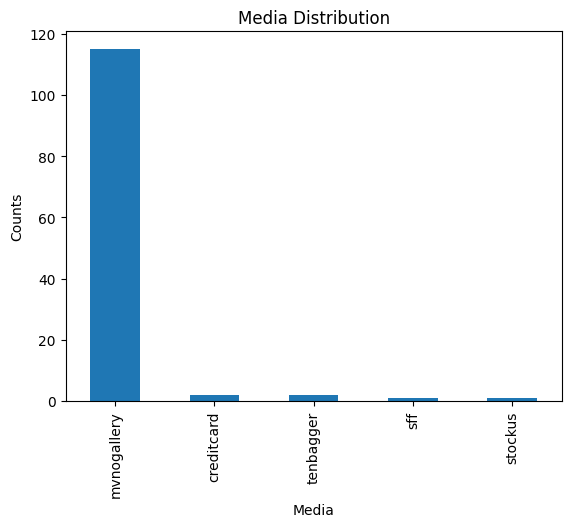

In [78]:
media_counts_11 = df_topic_11['media'].value_counts()
media_counts_11.plot(kind='bar', title='Media Distribution')
plt.xlabel('Media')
plt.ylabel('Counts')
plt.show()

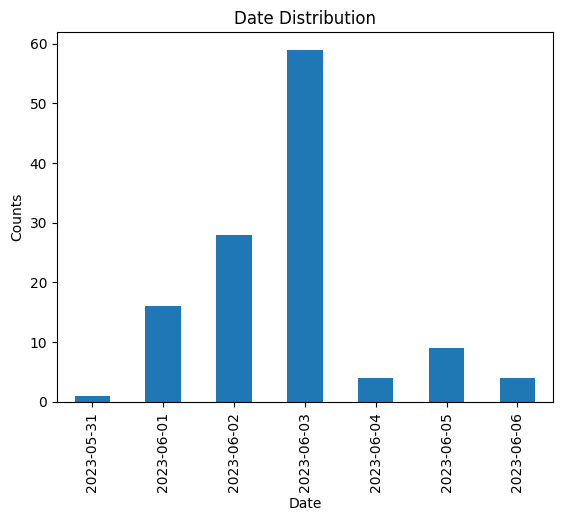

In [79]:
# 'date' 칼럼의 날짜별 분포 시각화
date_counts_11 = df_topic_11['date'].value_counts().sort_index()
date_counts_11.plot(kind='bar', title='Date Distribution')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

### 4-b. topic 2

In [75]:
df_topic_2 = df_178[df_178['topic'] == 2]
df_topic_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 10 to 1865
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            156 non-null    object
 1   title           156 non-null    object
 2   url             156 non-null    object
 3   media           156 non-null    object
 4   content         156 non-null    object
 5   is_comment      156 non-null    int64 
 6   week            156 non-null    int64 
 7   spaced_content  156 non-null    object
 8   tokens          156 non-null    object
 9   bigrams         156 non-null    object
 10  tokens_str      156 non-null    object
 11  topic           156 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 15.8+ KB


In [76]:
df_topic_2.head(10)

,date,title,url,media,content,is_comment,week,spaced_content,tokens,bigrams,tokens_str,topic
10,2023-05-31,토스 Tio 종토방 보니,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,토스 Tio 종토방 보니 이새끼들은 주가가 내리는 이유가 공매도밖에 없는걸로 아는듯,0,178,토스 Tio 종토방 보니 이 새끼들은 주가가 내리는 이 유가 공매도 밖에 없는 걸로...,"['토스', '종토방', '주가', '내리', '유가', '공매도']","['토스 종토방', '종토방 주가', '주가 내리', '내리 유가', '유가 공매도']",토스 종토방 주가 내리 유가 공매도,2
15,2023-05-31,토스<-는 느그애비 똥꾸녕같은 앱이다,https://gall.dcinside.com/board/view/?id=credi...,creditcard,토스<-는 느그애비 똥꾸녕같은 앱이다 더럽고 지저분하다사실을 말할뿐반박시 느그애비좆물끝,0,178,토스 <-는 느 그 애비 똥꾸녕 같은 앱이 다 더럽고 지저분하다 사실을 말할 뿐 반...,"['토스', '애비', '더럽', '사실', '반박', '애비']","['토스 애비', '애비 더럽', '더럽 사실', '사실 반박', '반박 애비']",토스 애비 더럽 사실 반박 애비,2
53,2023-06-01,슈바 모빙 SK 0원 탄지 2주밖에 안되었는데 토스 바꿀까??,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,먼데 토스,1,178,먼데 토스,['토스'],['토스'],토스,2
57,2023-06-01,서브 개같이 토스 드가자잇 ㅋㅋㅋㅋㅋㅋㅋㅋ,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,서브 개같이 토스 드가자잇 ㅋㅋㅋㅋㅋㅋㅋㅋ 홈플 상품권 털엇고 토스로 갈아타야징 ㅋㅋ,0,178,서브 개같이 토스 드가 자 잇 ㅋㅋㅋㅋㅋㅋㅋㅋ 홈플 상품권 털엇고 토스로 갈아타야 ...,"['서브', '토스', '드가', '상품권', '토스', '갈아타']","['서브 토스', '토스 드가', '드가 상품권', '상품권 토스', '토스 갈아타']",서브 토스 드가 상품권 토스 갈아타,2
77,2023-06-01,슈바 모빙 SK 0원 탄지 2주밖에 안되었는데 토스 바꿀까??,https://gall.dcinside.com/mgallery/board/view/...,mvnogallery,토스는 안된다는 듯,1,178,토스는 안 된다는 듯,['토스'],['토스'],토스,2
82,2023-06-01,9200가까이 토스 파킹해도 세후 5000원이네 십얼,https://gall.dcinside.com/mgallery/board/view/...,stockus,뭣하러 토스에다가 파킹함? 파킹할곳 많은데,1,178,뭣하러 토스에 다가 파킹함 ? 파킹할 곳 많은데,"['토스', '파킹', '파킹']","['토스 파킹', '파킹 파킹']",토스 파킹 파킹,2
84,2023-06-01,토스 종토방이 진짜 급식티 못벗어난 애들도 많고,https://gall.dcinside.com/mgallery/board/view/...,stockus,토스 종토방이 진짜 급식티 못벗어난 애들도 많고 좆같은 짤 처 올리는 틀딱도 되게 ...,0,178,토스 종토방이 진짜 급식 티 못 벗어난 애들도 많고 좆 같은 짤 처 올리는 틀 딱도...,"['토스', '종토방', '급식', '올리', '특정', '캐릭터', '컨셉', '...","['토스 종토방', '종토방 급식', '급식 올리', '올리 특정', '특정 캐릭터...",토스 종토방 급식 올리 특정 캐릭터 컨셉 말투 보이,2
91,2023-06-01,유카 거래량 WLDS 거래량,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,유카 거래량 WLDS 거래량 유카 거래량 약 3천만주WLDS 거래량 1852만주토스...,0,178,유카 거래량 WLDS 거래량 유카 거래량 약 3천만주 WLDS 거래량 1852만주 ...,"['유카', '거래량', '거래량', '유카', '거래량', '천만', '거래량',...","['유카 거래량', '거래량 거래량', '거래량 유카', '유카 거래량', '거래량...",유카 거래량 거래량 유카 거래량 천만 거래량 만주 토스 일별 시세 지표,2
93,2023-06-01,근데 김치장은 주로 누가하는거야?,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,근데 김치장은 주로 누가하는거야? 토스줌마들이 하나?,0,178,근데 김치장은 주로 누가 하는 거야? 토스줌마들이 하나?,"['김치', '토스', '마들이', '하나']","['김치 토스', '토스 마들이', '마들이 하나']",김치 토스 마들이 하나,2
95,2023-06-01,팅고그룹은 좆박고있는데 애들이 뭘믿는거냐,https://gall.dcinside.com/mgallery/board/view/...,tenbagger,팅고그룹은 좆박고있는데 애들이 뭘믿는거냐 토스팅고종토방은 뭘믿고있는거냐대체,0,178,팅고그룹은 좆 박고 있는데 애들이 뭘 믿는 거냐 토스팅 고종 토방은 뭘 믿고 있는 ...,"['그룹', '토스', '고종', '토방', '대체']","['그룹 토스', '토스 고종', '고종 토방', '토방 대체']",그룹 토스 고종 토방 대체,2


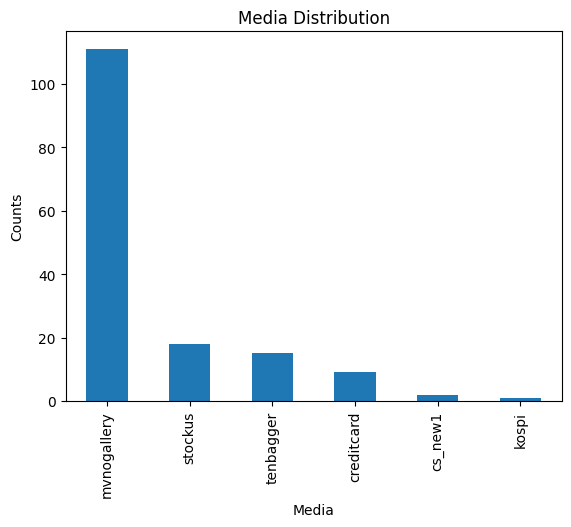

In [77]:
media_counts_2 = df_topic_2['media'].value_counts()
media_counts_2.plot(kind='bar', title='Media Distribution')
plt.xlabel('Media')
plt.ylabel('Counts')
plt.show()

### 4-c. topic 